In [1]:
import os

import copy

import galarp as grp

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import animation

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter

from tqdm import tqdm



# Full GalaRP Testing Suite

1. Constant strong wind (CWSTRONG), "standard" distribution, no shadow. 

2. CWSTRONG, extremely strong shadow.
3. CWSTRONG, very weak shadow
4. CWSTRONG, no shadow, only particles between 1-5 kpc
5. CWSTRONG, no shadow, only particles between 5-8 kpc
6. CWSTRONG, no shadow, only particles between 10-13 kpc
7. CWSTRONG, no shadow, only particles between 15-18 kpc

### Wind types

A: CWSTRONG

B: Slowly increasing to max wind

C: Lorentzian wind


In [2]:
# Gen filestructure
topdir = "figures/fullsuite/"
tempdir = "temp/fullsuite/"

subdirs = ["A", "B", "C", "D"]


for subdir in subdirs:
    os.makedirs(topdir + subdir, exist_ok=True)
    os.makedirs(tempdir + subdir, exist_ok=True)


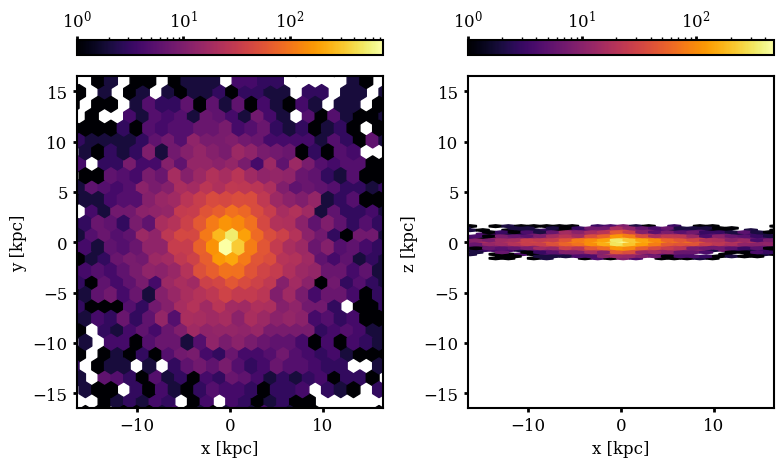

In [38]:
inclination_angles = [0, 15, 30, 45, 60, 75, 90]

potential = grp.builtins.RB2006_Satellite()
mass_profile = grp.gen_mass_profile(potential)

n_particles = 10000

position_fn = "temp/fullsuite/exponential_positions.npy"
if not os.path.exists(position_fn):
    print("File doesn't exist, regenerating particles")

    particles = grp.ExponentialDistribution(h_R = potential["gas"].parameters["a"].value, h_z = potential["gas"].parameters["b"].value, n_particles = n_particles, units=galactic)
    particles.save_positions(position_fn)
else:
    particles = grp.ParticleDistribution.from_file(position_fn, units=galactic)


mass_fn, radius_fn = "temp/fullsuite/mass.npy", "temp/fullsuite/radius.npy"
if not os.path.exists(mass_fn):
    masses = np.random.uniform(1e5, 5e6, size=n_particles)
    np.save(mass_fn, masses)
else:
    masses = np.load(mass_fn)

if not os.path.exists(radius_fn):
    radii = np.random.uniform(1, 10, size=n_particles)
    np.save(radius_fn, radii)
else:
    radii = np.load(radius_fn)


pset = grp.ParticleSet(particles, units=galactic)
pset.generate(mass_profile=mass_profile)

particles.plot_positions(outname="figures/fullsuite/particles.png")

# Create particles for runs 4,5,6 and 7

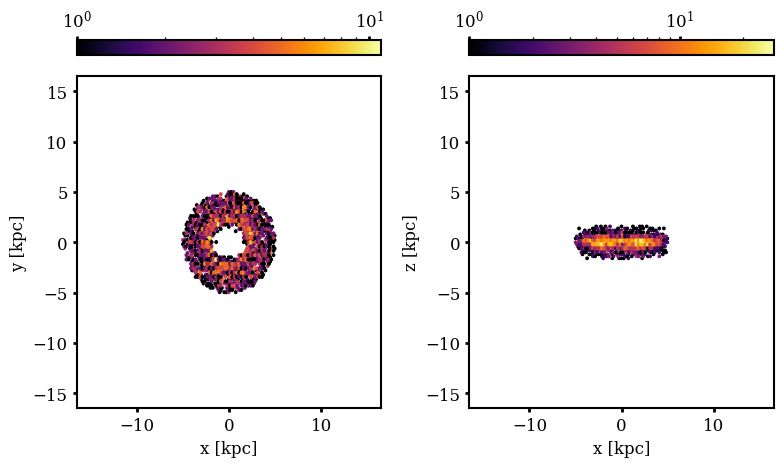

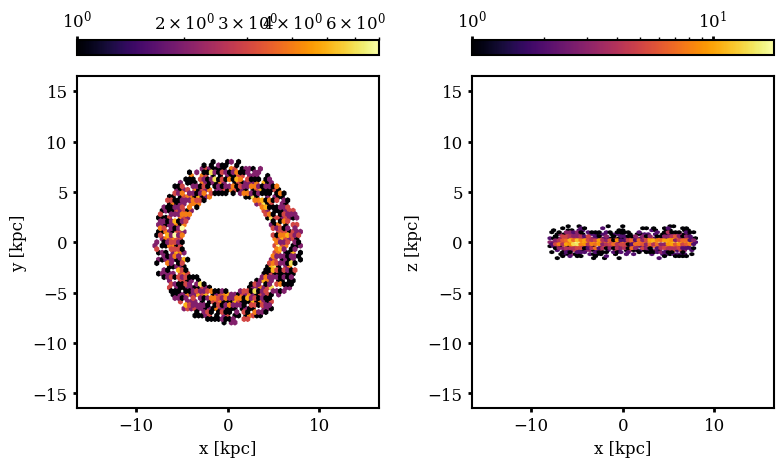

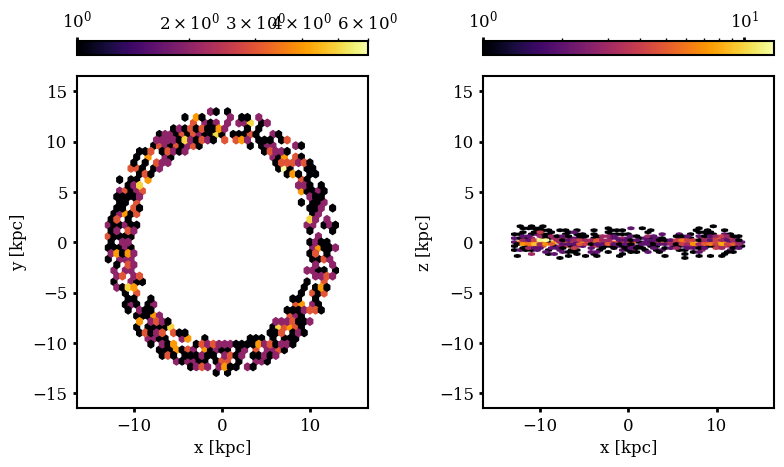

In [39]:
def cut_particles(particles_to_cut, rmin=0, rmax=50):
    x,y,z = particles_to_cut.x, particles_to_cut.y, particles_to_cut.z
    r = np.sqrt(x**2 + y**2 + z**2).value

    mask = (r > rmin) & (r < rmax)
    particles_to_cut.x = particles_to_cut.x[mask]
    particles_to_cut.y = particles_to_cut.y[mask]
    particles_to_cut.z = particles_to_cut.z[mask]

    return particles_to_cut


particles_4 = copy.deepcopy(particles)
particles_4 = cut_particles(particles_4, rmin=2, rmax=5)
particles_4.plot_positions(outname="figures/fullsuite/particles_4.png")
pset_4 = grp.ParticleSet(particles_4, units=galactic)
pset_4.generate(mass_profile=mass_profile)

particles_5 = copy.deepcopy(particles)
particles_5 = cut_particles(particles_5, rmin=5, rmax=8)
particles_5.plot_positions(outname="figures/fullsuite/particles_5.png")
pset_5 = grp.ParticleSet(particles_5, units=galactic)
pset_5.generate(mass_profile=mass_profile)

particles_6 = copy.deepcopy(particles)
particles_6 = cut_particles(particles_6, rmin=10, rmax=13)
particles_6.plot_positions(outname="figures/fullsuite/particles_8.png")
pset_6 = grp.ParticleSet(particles_6, units=galactic)
pset_6.generate(mass_profile=mass_profile)


[1.000000e+00 0.000000e+00 6.123234e-17]


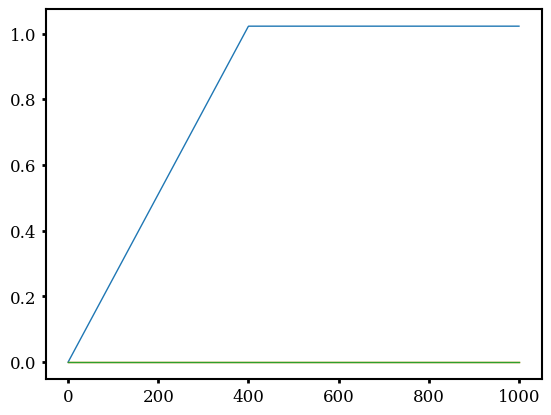

In [40]:
def gradual_to_constant_peak(inc = 45., peak=800., time_to_max=100.):

    peak = peak * (u.km/u.s).to(u.kpc / u.Myr)

    i_x, i_y = np.linspace(0, time_to_max, 50), np.linspace(0, peak, 50)

    i_x = np.concatenate([i_x, np.linspace(time_to_max, 1000, 950)])
    i_y = np.concatenate([i_y, peak * np.ones(950)])

    #plt.plot(i_x, i_y)

    interp = interp1d(i_x, i_y, bounds_error=False, fill_value="extrapolate")

    wind = grp.InterpolatedStrengthWind(interp=interp, inclination=np.deg2rad(inc), units=galactic)

    return wind


CWGRADUAL = gradual_to_constant_peak(inc=90, peak=1000, time_to_max=400)

print(CWGRADUAL.unit_vector)

times = np.linspace(0, 1000, 1000)
velocities = CWGRADUAL.evaluate_arr(times).T

for v in velocities:
    plt.plot(times, v)

# plt.plot(*velocities)

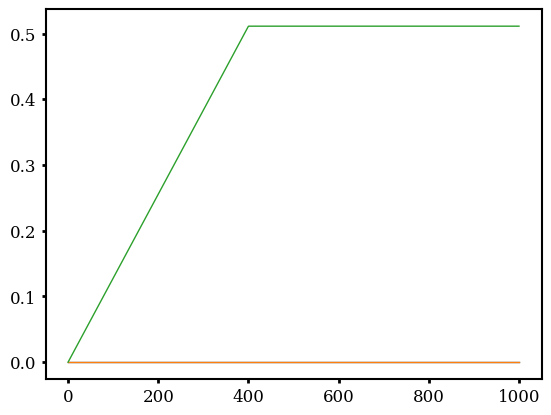

In [36]:
CWGRADUAL = grp.builtins.gradual_to_constant_peak(inc=0, peak=500, time_to_max=400)

times = np.linspace(0, 1000, 1000)
velocities = CWGRADUAL.evaluate_arr(times).T

for v in velocities:
    plt.plot(times, v)



In [8]:
orbit_containers_A1 = []
orbit_containers_A2 = []
orbit_containers_A3 = []
orbit_containers_A4 = []

for inc in inclination_angles:

    CWSTRONG = grp.builtins.RB2006_Wind(inc=inc, peak=800)

    strong_shadow = grp.DynamicShadowMasses(wind=CWSTRONG, a_disk= 4 * potential["gas"].parameters["a"].value, 
                                            b_disk= 4 * potential["gas"].parameters["b"].value, depth = 1e9,
                                            masses=masses, radii=radii)
    weak_shadow = grp.DynamicShadowMasses(wind=CWSTRONG, a_disk= 4 * potential["gas"].parameters["a"].value,
                                            b_disk= 4 * potential["gas"].parameters["b"].value, depth = 5e10,
                                            masses=masses, radii=radii)

    sim_1 = grp.RPSim(wind=CWSTRONG, potential=potential, shadow=None)

    orbits = sim_1.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"A/A1_{inc}.grp")
    # orbit_containers_A1.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/A/GRPSIM_A1_{inc}.gif", n_frames=100, imax=600, cmap=cmap)

    sim_2 = grp.RPSim(wind=CWSTRONG, potential=potential, shadow=strong_shadow)
    orbits = sim_2.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"A/A2_{inc}.grp")
    # orbit_containers_A2.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/A/GRPSIM_A2_{inc}.gif", n_frames=100, imax=600, cmap=cmap)


    sim_3 = grp.RPSim(wind=CWSTRONG, potential=potential, shadow=weak_shadow)
    orbits = sim_3.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"A/A3_{inc}.grp")
    # orbit_containers_A3.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/A/GRPSIM_A3_{inc}.gif", n_frames=100, imax=600, cmap=cmap)


    sim_4 = grp.RPSim(wind=CWSTRONG, potential=potential, shadow=None)
    orbits = sim_4.run(pset_4, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"A/A4_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/A/GRPSIM_A4_{inc}.gif", n_frames=100, imax=600, cmap=cmap)


    sim_5 = grp.RPSim(wind=CWSTRONG, potential=potential, shadow=None)
    orbits = sim_5.run(pset_5, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"A/A5_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/A/GRPSIM_A5_{inc}.gif", n_frames=100, imax=600, cmap=cmap)

    
    sim_6 = grp.RPSim(wind=CWSTRONG, potential=potential, shadow=None)
    orbits = sim_6.run(pset_6, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"A/A6_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/A/GRPSIM_A6_{inc}.gif", n_frames=100, imax=600, cmap=cmap)



100%|██████████| 999/999 [00:04<00:00, 235.71it/s]
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 999/999 [00:02<00:00, 440.19it/s]
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 999/999 [00:02<00:00, 454.75it/s]
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of emp

# Suite B -> Gradually Increasing Wind

In [42]:
imax = 800
for inc in inclination_angles:

    CWGRADUAL = grp.builtins.gradual_to_constant_peak(inc=inc, peak=800, time_to_max=800)

    strong_shadow = grp.DynamicShadowMasses(wind=CWGRADUAL, a_disk= 4 * potential["gas"].parameters["a"].value, 
                                            b_disk= 4 * potential["gas"].parameters["b"].value, depth = 1e9,
                                            masses=masses, radii=radii)
    weak_shadow = grp.DynamicShadowMasses(wind=CWGRADUAL, a_disk= 4 * potential["gas"].parameters["a"].value,
                                            b_disk= 4 * potential["gas"].parameters["b"].value, depth = 5e10,
                                            masses=masses, radii=radii)

    # strong_shadow = grp.DynamicShadow(wind=CWSTRONG, masses=masses, radii=radii * 2, tau_wind=1 * u.Myr)
    # weak_shadow = grp.DynamicShadow(wind=CWSTRONG, masses=masses, radii=radii, tau_wind=10 * u.Myr)

    sim_1 = grp.RPSim(wind=CWGRADUAL, potential=potential, shadow=None)

    orbits = sim_1.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"B/B1_{inc}.grp")
    # orbit_containers_A1.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/B/GRPSIM_B1_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)

    sim_2 = grp.RPSim(wind=CWGRADUAL, potential=potential, shadow=strong_shadow)
    orbits = sim_2.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"B/B2_{inc}.grp")
    # orbit_containers_A2.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/B/GRPSIM_B2_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)


    sim_3 = grp.RPSim(wind=CWGRADUAL, potential=potential, shadow=weak_shadow)
    orbits = sim_3.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"B/B3_{inc}.grp")
    # orbit_containers_A3.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/B/GRPSIM_B3_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)


    sim_4 = grp.RPSim(wind=CWGRADUAL, potential=potential, shadow=None)
    orbits = sim_4.run(pset_4, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"B/B4_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/B/GRPSIM_B4_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)


    sim_5 = grp.RPSim(wind=CWGRADUAL, potential=potential, shadow=None)
    orbits = sim_5.run(pset_5, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"B/B5_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/B/GRPSIM_B5_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)

    
    sim_6 = grp.RPSim(wind=CWGRADUAL, potential=potential, shadow=None)
    orbits = sim_6.run(pset_6, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"B/B6_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/B/GRPSIM_B6_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)

100%|██████████| 999/999 [00:02<00:00, 449.39it/s]


# Suite C -> Lorentzian Wind

In [45]:
imax = 800
for inc in inclination_angles:

    CWLORENTZ = grp.LorentzianWind(t0 = 500 * u.Myr, width = 400 * u.Myr, strength = 1200)

    strong_shadow = grp.DynamicShadowMasses(wind=CWLORENTZ, a_disk= 4 * potential["gas"].parameters["a"].value, 
                                            b_disk= 4 * potential["gas"].parameters["b"].value, depth = 1e9,
                                            masses=masses, radii=radii)
    weak_shadow = grp.DynamicShadowMasses(wind=CWLORENTZ, a_disk= 4 * potential["gas"].parameters["a"].value,
                                            b_disk= 4 * potential["gas"].parameters["b"].value, depth = 5e10,
                                            masses=masses, radii=radii)

    # strong_shadow = grp.DynamicShadow(wind=CWSTRONG, masses=masses, radii=radii * 2, tau_wind=1 * u.Myr)
    # weak_shadow = grp.DynamicShadow(wind=CWSTRONG, masses=masses, radii=radii, tau_wind=10 * u.Myr)

    sim_1 = grp.RPSim(wind=CWLORENTZ, potential=potential, shadow=None)

    orbits = sim_1.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"C/C1_{inc}.grp")
    # orbit_containers_A1.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/C/GRPSIM_C1_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)

    sim_2 = grp.RPSim(wind=CWLORENTZ, potential=potential, shadow=strong_shadow)
    orbits = sim_2.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"C/C2_{inc}.grp")
    # orbit_containers_A2.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/C/GRPSIM_C2_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)


    sim_3 = grp.RPSim(wind=CWLORENTZ, potential=potential, shadow=weak_shadow)
    orbits = sim_3.run(pset, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"C/C3_{inc}.grp")
    # orbit_containers_A3.append(orbits)
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/C/GRPSIM_C3_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)


    sim_4 = grp.RPSim(wind=CWLORENTZ, potential=potential, shadow=None)
    orbits = sim_4.run(pset_4, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"C/C4_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/C/GRPSIM_C4_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)


    sim_5 = grp.RPSim(wind=CWLORENTZ, potential=potential, shadow=None)
    orbits = sim_5.run(pset_5, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"C/C5_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/C/GRPSIM_C5_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)

    
    sim_6 = grp.RPSim(wind=CWLORENTZ, potential=potential, shadow=None)
    orbits = sim_6.run(pset_6, integration_time=2000 * u.Myr, dt=2*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbits.save(tempdir + f"C/C6_{inc}.grp")
    grp.animated_hexbin_plot(orbits, outname=f"figures/fullsuite/C/GRPSIM_C6_{inc}.gif", n_frames=100, imax=imax, cmap=cmap)

/Users/hsouchereau/galarp/galarp/winds.py:54: UserWarning: The wind strength (1200.0 kpc / Myr) is quite high. Are your units correct?
  warnings.warn(f"The wind strength ({self.strength}) is quite high. Are your units correct?")
  0%|          | 0/999 [00:00<?, ?it/s]/Users/hsouchereau/galarp/galarp/rampressure.py:75: RuntimeWarning: overflow encountered in square
  a_ram = (v_perp**2) * (rho.evaluate(t) / sigma_gas).to(1 / u.kpc).value[:, np.newaxis] * np.sign(v_perp)
  5%|▌         | 50/999 [00:01<00:20, 46.16it/s]